## **Decision Tree from Scratch**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.colors import ListedColormap

The *generate_data* function creates synthetic data with various noise patterns and with non linearly separable classes. Also, there's significant overlap between classes. We also built *train_test_split* to divide data for model training and testing.

In [3]:
def generate_data(n_samples=1000, n_features=2, n_clusters=3, noise_level=0.8, overlap_factor=0.5):
    """Generate challenging synthetic binary classification data with multiple clusters and overlap."""
    n_samples = (n_samples // 2) * 2
    n_samples_per_class = n_samples // 2
    n_samples_per_cluster = n_samples_per_class // n_clusters
    
    X_list = []
    y_list = []
    
    def generate_positive_semidefinite_matrix(n):
        A = np.random.uniform(-0.5, 0.5, (n, n))
        return np.dot(A, A.T) + np.eye(n)
    
    for i in range(n_clusters):
        cluster_center = np.random.uniform(-5, 5, n_features)
        covariance = generate_positive_semidefinite_matrix(n_features)
        covariance *= np.random.uniform(0.5, 2.0)
        cluster_samples = np.random.multivariate_normal(
            cluster_center,
            covariance,
            n_samples_per_cluster
        )
        X_list.append(cluster_samples)
        y_list.append(np.zeros(n_samples_per_cluster))
    
    for i in range(n_clusters):
        base_center = np.random.uniform(-5, 5, n_features)
        cluster_center = base_center + np.random.normal(0, overlap_factor, n_features)
        covariance = generate_positive_semidefinite_matrix(n_features)
        covariance *= np.random.uniform(0.5, 2.0)
        cluster_samples = np.random.multivariate_normal(
            cluster_center,
            covariance,
            n_samples_per_cluster
        )
        X_list.append(cluster_samples)
        y_list.append(np.ones(n_samples_per_cluster))
    
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    
    X += np.random.normal(0, noise_level, X.shape)
    
    n_outliers = int(0.05 * len(X))  
    outlier_idx = np.random.choice(len(X), n_outliers, replace=False)
    X[outlier_idx] += np.random.normal(0, noise_level * 3, (n_outliers, n_features))
    
    shuffle_idx = np.random.permutation(len(X))
    return X[shuffle_idx], y[shuffle_idx].astype(int)

def train_test_split(X, y, test_size=0.2, random_state=None):
    """Split arrays into random train and test subsets"""
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)
    test_samples = int(n_samples * test_size)
    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

The *Node* class represents a node in the tree, which can be either:

- A decision node (with a feature and threshold for splitting)
- A leaf node (with a predicted value)


The *DecisionTree* class builds a binary tree that:

- Recursively splits data based on features and thresholds
- Uses information gain (based on entropy) to find the best splits
- Stops growing when it reaches maximum depth or minimum samples
- Makes predictions by traversing the tree based on feature values


The tree grows top-down by:

1- Finding the best split at each node
2- Creating left and right branches based on the split
3- Continuing until stopping criteria are met
4- Using majority voting at leaf nodes for predictions

Think of it like a flowchart where each internal node asks a yes/no question about a feature (e.g., "Is feature 1 < 0.5?"), and the leaves provide the final classification decisions.

In [5]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=10, min_samples_split=5):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        
    def fit(self, X, y):
        y = y.astype(int)
        self.n_classes = len(np.unique(y))
        self.root = self._grow_tree(X, y)
        
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           n_labels == 1:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
            
        left_idxs = X[:, best_feature] < best_threshold
        right_idxs = ~left_idxs
        
        if np.sum(left_idxs) == 0 or np.sum(right_idxs) == 0:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
            
        left = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)
        
        return Node(best_feature, best_threshold, left, right)
    
    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        for feature in range(X.shape[1]):
            feature_values = X[:, feature]
            thresholds = np.percentile(feature_values, np.linspace(10, 90, 10))
            
            for threshold in thresholds:
                gain = self._information_gain(feature_values, y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
                    
        return best_feature, best_threshold
    
    def _information_gain(self, X_column, y, threshold):
        parent_entropy = self._entropy(y)
        
        left_idxs = X_column < threshold
        right_idxs = ~left_idxs
        
        if np.sum(left_idxs) == 0 or np.sum(right_idxs) == 0:
            return 0
        
        n = len(y)
        n_l, n_r = np.sum(left_idxs), np.sum(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
        
        return parent_entropy - child_entropy
    
    def _entropy(self, y):
        y = y.astype(int)
        hist = np.bincount(y)
        ps = hist / len(y)
        ps = ps[ps > 0]
        return -np.sum(ps * np.log2(ps))
    
    def _most_common_label(self, y):
        y = y.astype(int)
        unique_labels, counts = np.unique(y, return_counts=True)
        return unique_labels[np.argmax(counts)]
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        
        if x[node.feature] < node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

These functions are used to plot the raw data and the decision boundary used in classification, the structure of the decision tree and the model performance metrics.

In [7]:
def plot_data_and_decision_boundary(X_train, X_test, y_train, y_test, tree=None):
    """
    Plot the dataset and decision boundary, distinguishing between train and test sets
    with corrected background colors matching the classes
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], 
                c='blue', label='Train Class 0', alpha=0.5, marker='o')
    ax1.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], 
                c='red', label='Train Class 1', alpha=0.5, marker='o')
    ax1.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], 
                c='blue', label='Test Class 0', alpha=0.5, marker='^')
    ax1.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], 
                c='red', label='Test Class 1', alpha=0.5, marker='^')
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")
    ax1.set_title("Dataset")
    ax1.legend()
    
    if tree is not None:
        X = np.vstack([X_train, X_test])
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                            np.linspace(y_min, y_max, 100))
        
        Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        custom_cmap = ListedColormap(['lightblue', 'lightpink'])
        ax2.contourf(xx, yy, Z, alpha=0.4, cmap=custom_cmap)
        
        ax2.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], 
                   c='blue', label='Train Class 0', alpha=0.5, marker='o')
        ax2.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], 
                   c='red', label='Train Class 1', alpha=0.5, marker='o')
        ax2.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], 
                   c='blue', label='Test Class 0', alpha=0.5, marker='^')
        ax2.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], 
                   c='red', label='Test Class 1', alpha=0.5, marker='^')
        ax2.set_xlabel("Feature 1")
        ax2.set_ylabel("Feature 2")
        ax2.set_title("Decision Boundary")
        ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_decision_tree(node, feature_names=None, max_depth=None):
    """
    Create an improved visualization of the decision tree structure with better spacing and clarity
    
    Parameters:
    -----------
    node : Node object
        The root node of the tree
    feature_names : list of str, optional
        Names of the features
    max_depth : int, optional
        Maximum depth to display
    """
    def get_tree_structure(node, depth=0):
        if max_depth is not None and depth >= max_depth:
            return [], [], [], []
            
        if node is None:
            return [], [], [], []
            
        node_features = []
        node_thresholds = []
        node_depths = []
        node_classes = []
        
        if node.value is not None:
            node_features.append('')
            node_thresholds.append(None)
            node_depths.append(depth)
            node_classes.append(node.value)
        else:
            node_features.append(feature_names[node.feature] if feature_names else f"Feature {node.feature}")
            node_thresholds.append(node.threshold)
            node_depths.append(depth)
            node_classes.append(None)
            
            left_features, left_thresholds, left_depths, left_classes = get_tree_structure(node.left, depth + 1)
            right_features, right_thresholds, right_depths, right_classes = get_tree_structure(node.right, depth + 1)
            
            node_features.extend(left_features)
            node_features.extend(right_features)
            node_thresholds.extend(left_thresholds)
            node_thresholds.extend(right_thresholds)
            node_depths.extend(left_depths)
            node_depths.extend(right_depths)
            node_classes.extend(left_classes)
            node_classes.extend(right_classes)
            
        return node_features, node_thresholds, node_depths, node_classes
    
    features, thresholds, depths, classes = get_tree_structure(node)
    
    max_depth_found = max(depths)
    n_nodes = len(features)
    
    # Calculate the width needed for the plot based on the number of leaf nodes
    leaf_nodes = sum(1 for c in classes if c is not None)
    width = max(15, leaf_nodes * 2)
    height = max(8, (max_depth_found + 1) * 2)
    
    plt.figure(figsize=(width, height))
    
    # Improved node positioning
    def get_node_positions():
        positions = []
        level_widths = [2 ** d for d in range(max_depth_found + 1)]
        level_counts = [0] * (max_depth_found + 1)
        
        for i, depth in enumerate(depths):
            if classes[i] is not None:  # Leaf node
                # Calculate position based on the number of leaf nodes at this depth
                leaf_count = sum(1 for j, d in enumerate(depths) if d == depth and classes[j] is not None)
                level_width = level_widths[depth] * 1.5  # Increase spacing for leaf nodes
                position = (level_counts[depth] - leaf_count/2) * level_width/leaf_count
            else:  # Decision node
                level_width = level_widths[depth]
                position = (level_counts[depth] - level_widths[depth]/2) * level_width/level_widths[depth]
            
            positions.append(position)
            level_counts[depth] += 1
            
        return positions
    
    x_positions = get_node_positions()
    
    # Draw edges first (under nodes)
    for i in range(1, n_nodes):
        parent_idx = (i - 1) // 2
        
        # Calculate control points for curved edges
        start_x = x_positions[parent_idx]
        start_y = -depths[parent_idx]
        end_x = x_positions[i]
        end_y = -depths[i]
        
        # Create curved line using control points
        control_x = [start_x, (start_x + end_x)/2, end_x]
        control_y = [start_y, (start_y + end_y)/2, end_y]
        curve = plt.matplotlib.path.Path(
            [(x, y) for x, y in zip(control_x, control_y)],
            [plt.matplotlib.path.Path.MOVETO, plt.matplotlib.path.Path.CURVE3, plt.matplotlib.path.Path.CURVE3]
        )
        patch = plt.matplotlib.patches.PathPatch(curve, facecolor='none', edgecolor='gray', alpha=0.5, linewidth=1)
        plt.gca().add_patch(patch)
        
        # Add edge labels with better positioning
        if i % 2 == 1:  # Left edge
            label_x = (start_x + end_x)/2 - 0.3
            label_y = (start_y + end_y)/2
            plt.annotate('True', (label_x, label_y), 
                        bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.7, edgecolor='none'),
                        ha='right', va='center')
        else:  # Right edge
            label_x = (start_x + end_x)/2 + 0.3
            label_y = (start_y + end_y)/2
            plt.annotate('False', (label_x, label_y),
                        bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.7, edgecolor='none'),
                        ha='left', va='center')
    
    # Draw nodes
    for i in range(n_nodes):
        x = x_positions[i]
        y = -depths[i]
        
        if classes[i] is not None:
            node_color = 'lightgreen' if classes[i] == 1 else 'lightcoral'
            node_text = f'Class: {classes[i]}'
            node_size = 1000
            box_alpha = 0.6
        else:
            node_color = 'lightblue'
            node_text = f'{features[i]}\n< {thresholds[i]:.2f}'
            node_size = 2000
            box_alpha = 0.8
        
        # Draw node with border
        plt.scatter(x, y, s=node_size, c=node_color, alpha=box_alpha, edgecolor='gray', linewidth=1)
        
        # Add text with improved visibility
        plt.annotate(node_text, (x, y), xytext=(0, 0), textcoords='offset points',
                    ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.5',
                            facecolor='white',
                            edgecolor='gray',
                            alpha=0.9))
    
    plt.title('Decision Tree Structure', pad=20, size=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()

def create_contingency_table(y_true, y_pred):
    """Create contingency table without using pandas"""
    classes = np.unique(np.concatenate([y_true, y_pred]))
    table = np.zeros((len(classes), len(classes)), dtype=int)
    for i, true_class in enumerate(classes):
        for j, pred_class in enumerate(classes):
            table[i, j] = np.sum((y_true == true_class) & (y_pred == pred_class))
    return table

def evaluate_model_performance(y_true, y_pred):
    """
    Calculate comprehensive model performance statistics
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
        
    Returns:
    --------
    dict : Performance metrics and statistical tests
    """
    accuracy = np.mean(y_true == y_pred)
    
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = ((tp * tn) - (fp * fn)) / denominator if denominator > 0 else 0
    
    contingency_table = create_contingency_table(y_true, y_pred)
    chi2, chi2_pval = stats.chi2_contingency(contingency_table)[:2]
    
    b = fn  
    c = fp  
    if b + c > 0:  
        mcnemar_stat = (abs(b - c) - 1)**2 / (b + c)
        mcnemar_pval = stats.chi2.sf(mcnemar_stat, df=1)
    else:
        mcnemar_stat = 0
        mcnemar_pval = 1.0
    
    pe = ((tp + fp) * (tp + fn) + (tn + fp) * (tn + fn)) / (total := len(y_true)**2)
    po = (tp + tn) / len(y_true)
    kappa = (po - pe/len(y_true)) / (1 - pe/len(y_true))
    
    successes = int(accuracy * len(y_true))
    binom_result = stats.binomtest(successes, n=len(y_true), p=0.5)
    binom_pval = binom_result.pvalue
    
    return {
        'Basic Metrics': {
            'Accuracy': accuracy,
            'Precision': precision,
            'Sensitivity/Recall': sensitivity,
            'Specificity': specificity,
            'F1 Score': f1_score,
            'Matthews Correlation Coefficient': mcc
        },
        'Confusion Matrix': {
            'True Negatives': tn,
            'False Positives': fp,
            'False Negatives': fn,
            'True Positives': tp
        },
        'Statistical Tests': {
            'Chi-square': {
                'statistic': chi2,
                'p-value': chi2_pval
            },
            "McNemar's Test": {
                'statistic': mcnemar_stat,
                'p-value': mcnemar_pval
            },
            "Cohen's Kappa": kappa,
            'Binomial Test p-value': binom_pval
        }
    }

def print_performance_report(metrics):
    """
    Print a formatted performance report
    
    Parameters:
    -----------
    metrics : dict
        Dictionary of performance metrics from evaluate_model_performance
    """
    print("\n=== MODEL PERFORMANCE REPORT ===\n")
    
    print("BASIC METRICS:")
    print("--------------")
    for metric, value in metrics['Basic Metrics'].items():
        print(f"{metric:30} : {value:.4f}")
    
    print("\nCONFUSION MATRIX:")
    print("----------------")
    for metric, value in metrics['Confusion Matrix'].items():
        print(f"{metric:30} : {value}")
    
    print("\nSTATISTICAL TESTS:")
    print("----------------")
    stats_tests = metrics['Statistical Tests']
    
    print(f"Chi-square Test:")
    print(f"    Statistic  : {stats_tests['Chi-square']['statistic']:.4f}")
    print(f"    P-value    : {stats_tests['Chi-square']['p-value']:.4f}")
    
    print(f"\nMcNemar's Test:")
    print(f"    Statistic  : {stats_tests['McNemar\'s Test']['statistic']:.4f}")
    print(f"    P-value    : {stats_tests['McNemar\'s Test']['p-value']:.4f}")
    
    print(f"\nCohen's Kappa : {stats_tests['Cohen\'s Kappa']:.4f}")
    print(f"Binomial Test P-value : {stats_tests['Binomial Test p-value']:.4f}")
    
    print("\nINTERPRETATION:")
    print("--------------")
    accuracy = metrics['Basic Metrics']['Accuracy']
    print(f"- Model achieves {accuracy:.1%} accuracy")
    
    if stats_tests['Binomial Test p-value'] < 0.05:
        print("- Performance is significantly better than random chance (p < 0.05)")
    else:
        print("- Performance is not significantly better than random chance (p >= 0.05)")
    
    if stats_tests['Chi-square']['p-value'] < 0.05:
        print("- Strong dependency between predictions and actual values (Chi-square p < 0.05)")
    
    kappa = stats_tests['Cohen\'s Kappa']
    if kappa > 0.8:
        kappa_interp = "excellent"
    elif kappa > 0.6:
        kappa_interp = "substantial"
    elif kappa > 0.4:
        kappa_interp = "moderate"
    else:
        kappa_interp = "fair to poor"
    print(f"- Agreement between predictions and actual values is {kappa_interp} (Kappa = {kappa:.2f})")

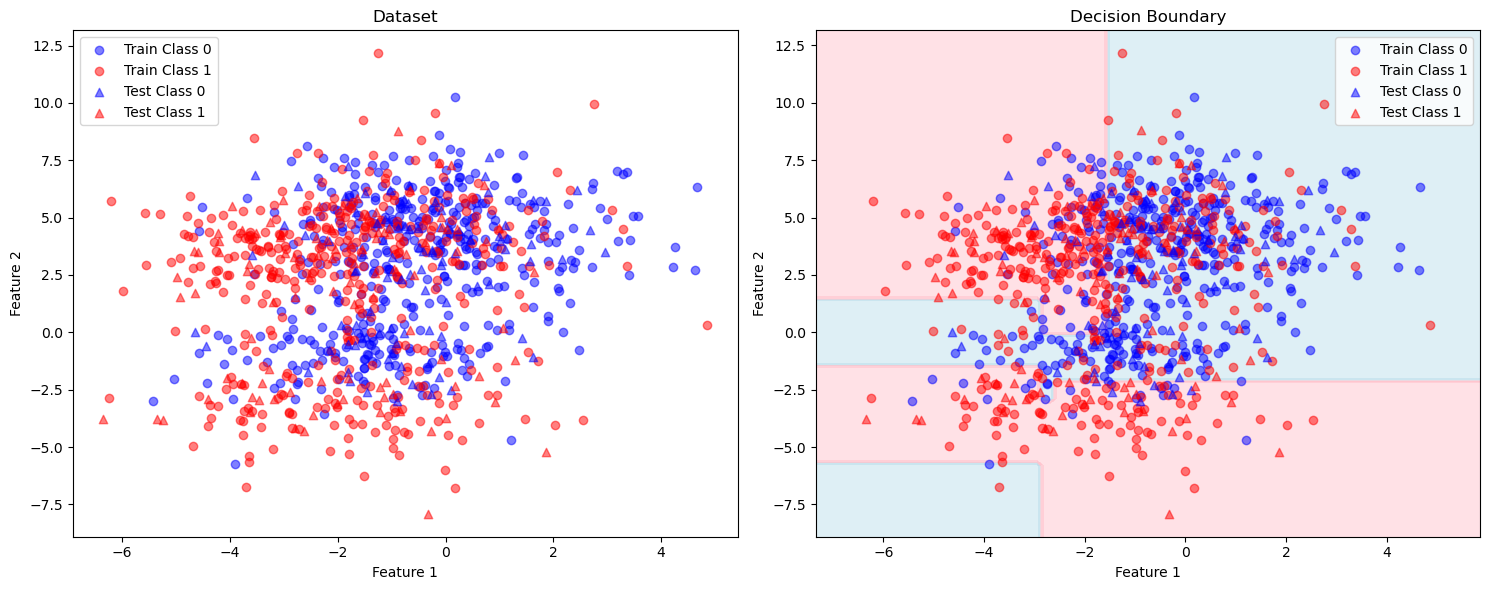

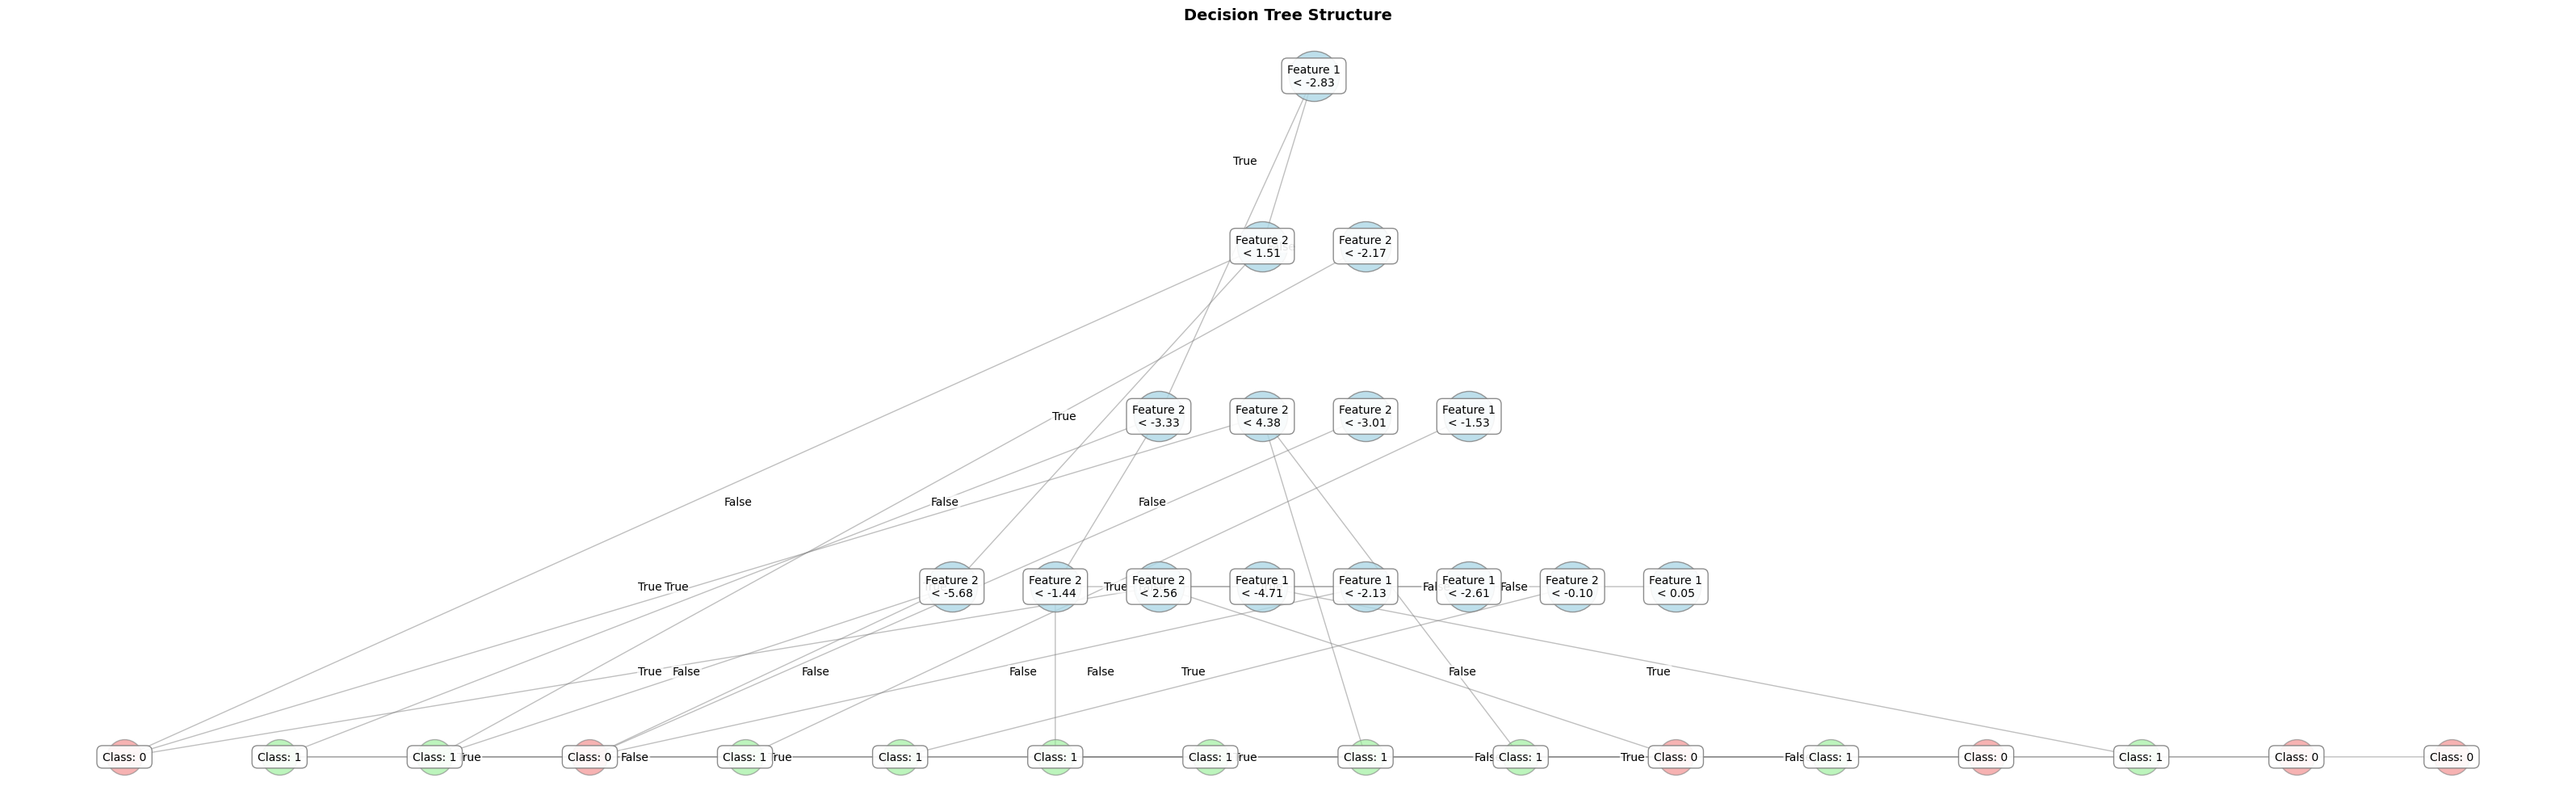


TRAINING SET PERFORMANCE:

=== MODEL PERFORMANCE REPORT ===

BASIC METRICS:
--------------
Accuracy                       : 0.7064
Precision                      : 0.7524
Sensitivity/Recall             : 0.6031
Specificity                    : 0.8069
F1 Score                       : 0.6695
Matthews Correlation Coefficient : 0.4193

CONFUSION MATRIX:
----------------
True Negatives                 : 326
False Positives                : 78
False Negatives                : 156
True Positives                 : 237

STATISTICAL TESTS:
----------------
Chi-square Test:
    Statistic  : 138.3805
    P-value    : 0.0000

McNemar's Test:
    Statistic  : 25.3376
    P-value    : 0.0000

Cohen's Kappa : 0.7062
Binomial Test P-value : 0.0000

INTERPRETATION:
--------------
- Model achieves 70.6% accuracy
- Performance is significantly better than random chance (p < 0.05)
- Strong dependency between predictions and actual values (Chi-square p < 0.05)
- Agreement between predictions and actual val

In [9]:
X, y = generate_data(n_samples=1000, n_features=2, n_clusters=3, noise_level=0.8, overlap_factor=0.5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

tree = DecisionTree(max_depth=4)  
tree.fit(X_train, y_train)

plot_data_and_decision_boundary(X_train, X_test, y_train, y_test, tree)

plot_decision_tree(tree.root, feature_names=["Feature 1", "Feature 2"])
plt.show()

train_predictions = tree.predict(X_train)
test_predictions = tree.predict(X_test)

print("\nTRAINING SET PERFORMANCE:")
train_metrics = evaluate_model_performance(y_train, train_predictions)
print_performance_report(train_metrics)

print("\nTEST SET PERFORMANCE:")
test_metrics = evaluate_model_performance(y_test, test_predictions)
print_performance_report(test_metrics)